In [1]:
from __future__ import print_function
import numpy as np
from copy import copy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
%matplotlib inline

In [2]:
# physical constants in MKS and Kelvin units unless specified otherwise
kB = 1.38064852e-23
c = 2.99792458e8 #m/s
h = 6.62607004e-34
TCMB = 2.726 #JCH (Rahul was using 2.732, not sure why)

In [3]:
# CMB blackbody (derivative) SED
def nu_be_CMB(nu):
    '''
    Input:
    nu = frequency [GHz]
    Output:
    CMB blackbody derivative SED in specific intensity units per K (W/m^2/Hz/sr/K)
    '''
    x = h*nu*1.e9/kB/TCMB
    return 2.*(kB*TCMB)**3. / (h*c)**2. * np.exp(x) * x**4. / (np.exp(x) - 1)**2. / TCMB #JCH: include prefactor

In [4]:
# tSZ SED
def nu_be_SZ(nu):
    '''
    Input:
    nu = frequency [GHz]
    Output
    tSZ SED in specific intensity units per K (W/m^2/Hz/sr/K)
    '''
    x = h*nu*1.e9/kB/TCMB
    return nu_be_CMB(nu) * (x * 1./np.tanh(x/2.) - 4.) #JCH: fix this (Rahul was missing the nu_be_CMB factor)

In [5]:
# modified blackbody (MBB) SED
def nu_be_MBB(nu, beta, T_dust = 9.6):
    '''
    Input:
    nu = frequency [GHz]
    beta = MBB spectral index
    T_dust = MBB temperature [K], default 9.6 K matches the likelihood code
    Output:
    MBB SED in specific intensity units (W/m^2/Hz/sr) WITH ARBITRARY OVERALL NORMALIZATION
    '''
    nu_arb = 100. #arbitrary reference frequency
    return (nu/nu_arb)**beta * 2*h*(nu*1.e9)**3./c**2. / (np.exp(h*nu*1.e9/kB/T_dust) - 1.)

In [6]:
# power-law in specific intensity units
def nu_be_PL(nu, beta):
    '''
    Input:
    nu = frequency [GHz]
    beta = power-law spectral index
    Output:
    power-law SED in specific intensity units (W/m^2/Hz/sr) WITH ARBITRARY OVERALL NORMALIZATION
    '''
    nu_arb = 100. #arbitrary reference frequency
    return (nu/nu_arb)**beta

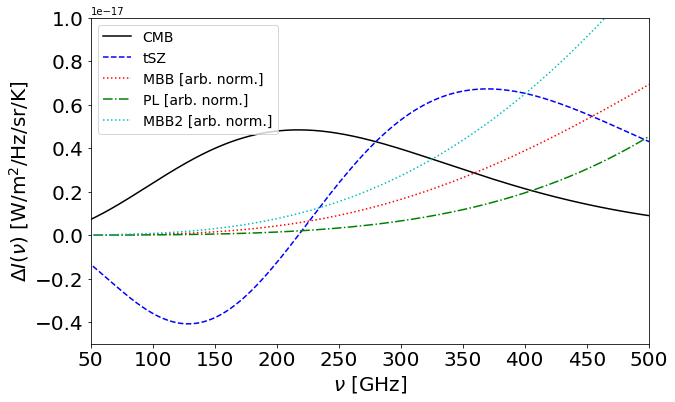

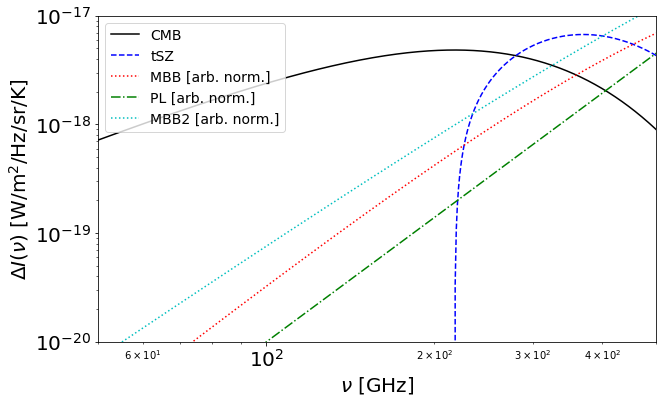

In [7]:
# test plot
nu_test = (np.linspace(1.,1000.,num=1000))
nu_be_CMB_test = nu_be_CMB(nu_test)
nu_be_SZ_test = nu_be_SZ(nu_test)
nu_be_MBB_test = nu_be_MBB(nu_test, 2.1)
nu_be_PL_test = nu_be_PL(nu_test, 3.8)
nu_be_MBB_test2 = nu_be_MBB(nu_test, 1.5, T_dust=19.6)

# linear axes
plt.figure(figsize=(10,6))
plt.plot(nu_test, nu_be_CMB_test, color='k', label='CMB')
plt.plot(nu_test, nu_be_SZ_test, color='b', label='tSZ', ls='--')
plt.plot(nu_test, nu_be_MBB_test/700., color='r', label='MBB [arb. norm.]', ls=':')
plt.plot(nu_test, nu_be_PL_test/1e20, color='g', label='PL [arb. norm.]', ls='-.')
plt.plot(nu_test, nu_be_MBB_test2/700., color='c', label='MBB2 [arb. norm.]', ls=':')
plt.tick_params(labelsize=20) 
plt.xlim(50.,500.)
plt.ylim(-0.5e-17,1.e-17)
plt.xlabel(r'$\nu$ [GHz]', fontsize=20)
plt.ylabel(r'$\Delta I(\nu)$ [W/m${}^2$/Hz/sr/K]', fontsize=20)
plt.legend(loc='upper left', fontsize=14)
plt.show()

# log axes
plt.figure(figsize=(10,6))
plt.plot(nu_test, nu_be_CMB_test, color='k', label='CMB')
plt.plot(nu_test, nu_be_SZ_test, color='b', label='tSZ', ls='--')
plt.plot(nu_test, nu_be_MBB_test/700., color='r', label='MBB [arb. norm.]', ls=':')
plt.plot(nu_test, nu_be_PL_test/1e20, color='g', label='PL [arb. norm.]', ls='-.')
plt.plot(nu_test, nu_be_MBB_test2/700., color='c', label='MBB2 [arb. norm.]', ls=':')
plt.tick_params(labelsize=20) 
plt.xlim(50.,500.)
plt.ylim(1.e-20,1.e-17)
plt.xlabel(r'$\nu$ [GHz]', fontsize=20)
plt.ylabel(r'$\Delta I(\nu)$ [W/m${}^2$/Hz/sr/K]', fontsize=20)
plt.legend(loc='upper left', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [8]:
# power-law SEDs
# match the likelihood code assumptions
be_s = -1.0 #Galactic synchrotron (alpha_gs in ACTPol_DR2.f90)
be_radio = -0.5  #radio Poisson sources (alpha_s in ACTPol_DR2.f90)
#be_ff = -0.1 #free-free #not used in the likelihood
# UPDATE 3-12-20: Galactic dust now modeled as a MBB in the likelihood
#be_d = 3.8 # "Galactic dust" (beta_g in ACTPol_DR2.f90)
#be_RJ = 2.0 #R-J #not used in the likelihood

# MBB SEDs
# match the likelihood code assumptions
# this is actually a free parameter in the likelihood, just approx via the Dunkley+2013 best-fit result
be_CIB = 2.1 # "CIB" (beta_c in ACTPol_DR2.f90)
# UPDATE 3-12-20: Galactic dust now modeled as a MBB in the likelihood
be_d = 1.5 #MBB index now, not power-law SED index
T_d_Gal = 19.6 #match likelihood code and Steve's foreground model

In [9]:
# read in ACTPol PA1/2/3 bandpass data
# these are the truncated/cleaned bandpasses produced in truncate_bandpasses.ipynb
# also include the PA3 bandpasses with "blue leak" appended (as extracted from PA6 data)
N_ACTPol = 6 #PA1, PA2, PA3_90, PA3_150, PA3_90_BL, PA3_150_BL
files_ACTPol = ['PA1_avg_passband_wErr_trunc_20200220.txt','PA2_avg_passband_wErr_trunc_20200220.txt','PA3_avg_passband_90_wErr_trunc_20200220.txt','PA3_avg_passband_150_wErr_trunc_20200220.txt','PA3_avg_passband_90_wErr_trunc_PA6_90_BL_added_20200220.txt','PA3_avg_passband_150_wErr_trunc_PA6_150_BL_added_20200220.txt']
nu_ACTPol = []
fnu_ACTPol = []
fnu_err_ACTPol = []

for i in range(N_ACTPol):
    nu_ACTPol.append(np.loadtxt(files_ACTPol[i])[:,0])
    fnu_ACTPol.append(np.loadtxt(files_ACTPol[i])[:,1])
    if (i < 4):
        fnu_err_ACTPol.append(np.loadtxt(files_ACTPol[i])[:,2])

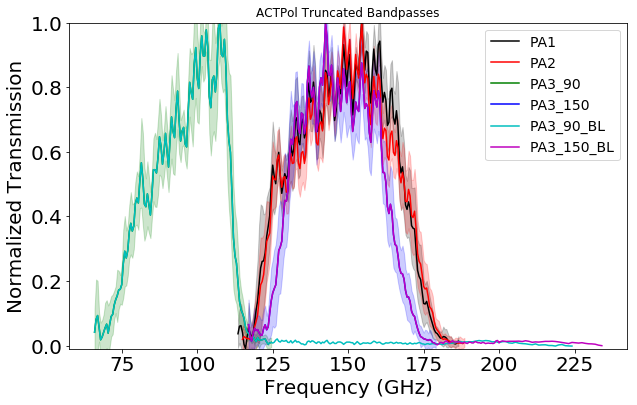

In [10]:
# plot to double check everything is OK
# plot truncated bandpasses
colors = ['k','r','g','b','c','m']
plt.figure(figsize=(10,6))
for i in range(N_ACTPol):
    plt.plot(nu_ACTPol[i], fnu_ACTPol[i], color=colors[i])
for i in range(4):
    plt.fill_between(nu_ACTPol[i], fnu_ACTPol[i]-fnu_err_ACTPol[i], fnu_ACTPol[i]+fnu_err_ACTPol[i], color=colors[i], alpha=0.2)
plt.tick_params(labelsize=20) 
plt.ylim(-0.01,1.)
plt.xlabel('Frequency (GHz)', fontsize=20)
plt.ylabel('Normalized Transmission', fontsize=20)
plt.legend(['PA1', 'PA2', 'PA3_90', 'PA3_150', 'PA3_90_BL', 'PA3_150_BL'], fontsize=14)
plt.title("ACTPol Truncated Bandpasses")
plt.show()
plt.savefig('PA123_bandpasses_trunc_noBL_vs_BL_20200222.pdf')

In [14]:
# Effective central frequency to diffuse sources -- note that compact sources differ!
# This uses the "weighted centroid" approach of Lyman
def central_freq(nu, fnu, SED_choice):
    '''
    Input:
    nu = frequencies at which bandpass is measured [GHz]
    fnu = bandpass transmission measurements [dimensionless]
    SED_choice = one of {CMB, tSZ, CIB, dust, radio, synch}
    Output:
    effective central frequency [GHz]
    '''
    assert(SED_choice is not None)
    if (SED_choice == 'CMB'):
        snu = nu_be_CMB(nu)
    elif (SED_choice == 'tSZ'):
        snu = nu_be_SZ(nu)
    elif (SED_choice == 'CIB'):
        snu = nu_be_MBB(nu, be_CIB, 9.6)
    elif (SED_choice == 'dust'):
        # UPDATE 3-12-20: Galactic dust now modeled as a MBB in the likelihood
        #snu = nu_be_PL(nu, be_d)
        snu = nu_be_MBB(nu, be_d, T_dust=T_d_Gal)
    elif (SED_choice == 'radio'):
        snu = nu_be_PL(nu, be_radio)
    elif (SED_choice == 'synch'):
        snu = nu_be_PL(nu, be_s)
    elif (SED_choice == 'flat'):
        snu = nu_be_PL(nu, 0.)
    else:
        print("unknown SED")
        return -np.inf
    # evaluate integral
    nu_cent = np.trapz(nu * fnu * snu, x=nu) / np.trapz(fnu * snu, x=nu)
    return nu_cent
    

In [15]:
# evaluate central frequency for CMB responses, as these cannot be computed via Hasselfield effective freq.
# note that these are NOT USED in the likelihood
for i in range(N_ACTPol):
    print('-------------')
    print(files_ACTPol[i])
    print("CMB:", central_freq(nu_ACTPol[i],fnu_ACTPol[i], 'CMB'))
    # compare to power-law with alpha=0
    print("flat:", central_freq(nu_ACTPol[i],fnu_ACTPol[i], 'flat'))

-------------
PA1_avg_passband_wErr_trunc_20200220.txt
CMB: 149.57289191141743
flat: 148.23515927144632
-------------
PA2_avg_passband_wErr_trunc_20200220.txt
CMB: 149.9440500863093
flat: 148.62576888062924
-------------
PA3_avg_passband_90_wErr_trunc_20200220.txt
CMB: 97.91625977599362
flat: 95.99448668962779
-------------
PA3_avg_passband_150_wErr_trunc_20200220.txt
CMB: 147.61697414092288
flat: 146.70911185423373
-------------
PA3_avg_passband_90_wErr_trunc_PA6_90_BL_added_20200220.txt
CMB: 102.00214818114522
flat: 98.17819541008201
-------------
PA3_avg_passband_150_wErr_trunc_PA6_150_BL_added_20200220.txt
CMB: 148.91803137602903
flat: 147.7835053127677


In [16]:
# Effective frequency to diffuse sources -- note that compact sources differ!
# This uses the Hasselfield Eq. 15 approach
# The effective frequency is defined as the solution nu0 of the equation
# 1/S(nu0) \int d\nu S(\nu) f(\nu) = 1/D_CMB(nu0) \int d\nu D_CMB(\nu) f(\nu)
# where S(\nu) is the SED of the component of interest
# and f(\nu) is the bandpass transmission
N_search = 400000
def eff_freq(nu, fnu, SED_choice):
    '''
    Input:
    nu = frequencies at which bandpass is measured [GHz]
    fnu = bandpass transmission measurements [dimensionless]
    SED_choice = one of {CMB, tSZ, CIB, dust, radio, synch}
    Output:
    effective frequency [GHz]
    '''
    assert(SED_choice is not None)
    # compute LHS of Eq. 15 on a grid
    # move the ratio of the nu0-related things to the LHS
    nu0_arr = np.linspace(np.min(nu),np.max(nu),num=N_search)
    snu0_CMB = nu_be_CMB(nu0_arr)
    LHS_numerator = snu0_CMB
    if (SED_choice == 'CMB'):
        #snu = nu_be_CMB(nu)
        print("eff. freq. undefined for CMB")
        return -np.inf
    elif (SED_choice == 'tSZ'):
        snu = nu_be_SZ(nu)
        snu0_arr = nu_be_SZ(nu0_arr)
    elif (SED_choice == 'CIB'):
        snu = nu_be_MBB(nu, be_CIB, 9.6)
        snu0_arr = nu_be_MBB(nu0_arr, be_CIB, 9.6)
    elif (SED_choice == 'dust'):
        # UPDATE 3-12-20: Galactic dust now modeled as a MBB in the likelihood
        #snu = nu_be_PL(nu, be_d)
        #snu0_arr = nu_be_PL(nu0_arr, be_d)
        snu = nu_be_MBB(nu, be_d, T_dust=T_d_Gal)
        snu0_arr = nu_be_MBB(nu0_arr, be_d, T_dust=T_d_Gal)
    elif (SED_choice == 'radio'):
        snu = nu_be_PL(nu, be_radio)
        snu0_arr = nu_be_PL(nu0_arr, be_radio)
    elif (SED_choice == 'synch'):
        snu = nu_be_PL(nu, be_s)
        snu0_arr = nu_be_PL(nu0_arr, be_s)
    elif (SED_choice == 'flat'):
        snu = nu_be_PL(nu, 0.)
        snu0_arr = nu_be_PL(nu0_arr, 0.)
    else:
        print("unknown SED")
        return -np.inf
    # evaluate integrals
    # RHS of Eq. 15, moving the ratio of the two integrals to the RHS
    RHS_numerator = np.trapz(fnu * nu_be_CMB(nu), x=nu)
    RHS_denominator = np.trapz(fnu * snu, x=nu)
    RHS = RHS_numerator / RHS_denominator
    # LHS of Eq. 15, with the ratio of the nu0-related things
    LHS_denominator = snu0_arr
    LHS_arr = LHS_numerator / LHS_denominator
    # solve Eq. 15
    ind_min = np.argmin(np.absolute(LHS_arr - RHS))
    nu_eff = nu0_arr[ind_min]
    return nu_eff


In [17]:
# evaluate effective frequencies
N_comps = 5
comps = ['tSZ','CIB','dust','radio','synch']
for i in range(N_ACTPol):
    print('-------------')
    print(files_ACTPol[i])
    for j in range(N_comps):
        print(comps[j], eff_freq(nu_ACTPol[i],fnu_ACTPol[i], comps[j]))


-------------
PA1_avg_passband_wErr_trunc_20200220.txt
tSZ 149.9960397650994
CIB 151.0292157980395
dust 150.91425626064066
radio 147.03501053752635
synch 146.90016117540293
-------------
PA2_avg_passband_wErr_trunc_20200220.txt
tSZ 150.36560228900572
CIB 151.41081642704106
dust 151.29598801497002
radio 147.42066690166723
synch 147.29114045285112
-------------
PA3_avg_passband_90_wErr_trunc_20200220.txt
tSZ 98.37933722334306
CIB 98.77450571126428
dust 98.60646404116011
radio 95.7586769216923
synch 95.47407371018427
-------------
PA3_avg_passband_150_wErr_trunc_20200220.txt
tSZ 147.90882959707398
CIB 148.61520741301854
dust 148.53322543306356
radio 145.92297498243744
synch 145.83200443001107
-------------
PA3_avg_passband_90_wErr_trunc_PA6_90_BL_added_20200220.txt
tSZ 103.47718331795829
CIB 106.51428081070202
dust 105.78850819627048
radio 97.3757125642814
synch 96.97724916812291
-------------
PA3_avg_passband_150_wErr_trunc_PA6_150_BL_added_20200220.txt
tSZ 149.34276083190207
CIB 150.669

(177,) (177,)


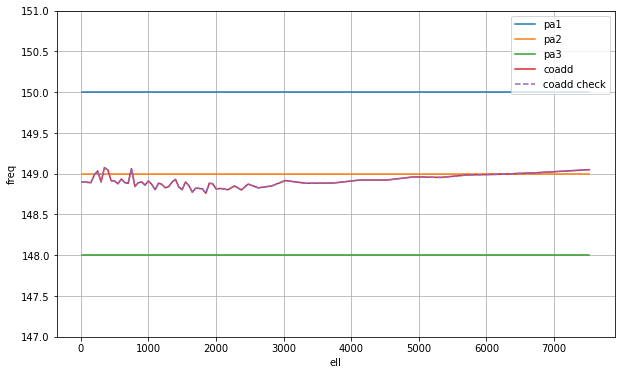

[  21.    60.5  103.   150.5  200.5  250.5  300.5  350.5  400.5  450.5
  500.5  550.5  600.5  650.5  700.5  750.5  800.5  850.5  900.5  950.5
 1000.5 1050.5 1100.5 1150.5 1200.5 1250.5 1300.5 1350.5 1400.5 1450.5
 1500.5 1550.5 1600.5 1650.5 1700.5 1750.5 1800.5 1850.5 1900.5 1950.5
 2000.5 2075.5 2175.5 2275.5 2375.5 2475.5 2625.5 2825.5 3025.5 3325.5
 3725.5 4125.5 4525.5 4925.5 5325.5 5725.5 6125.5 6725.5 7525.5]
3025.5


In [18]:
# co-add procedure for 150 GHz channels, using weights from Steve
# need to do separately for 15 mJy patches and 100 mJy patches
# example code from Steve in this cell -- note that he co-adds frequencies directly, which is not right

nbins = 59

ell_bin = np.genfromtxt('/home/jch/actpol_freq_w8_200204/ell_bin_200204.txt')
ipcov_ibin = np.load('/home/jch/actpol_freq_w8_200204/freq_w8_covmat_100mJy_200204.npy')

pa1_freq = 150.
pa2_freq = 149.
pa3_freq = 148.
freq = np.append(np.append(np.ones(nbins)*pa1_freq,np.ones(nbins)*pa2_freq),np.ones(nbins)*pa3_freq)

pa_arr = np.array([150.,149.,148.])
freq_check = np.ones(nbins)*pa_arr[0]
for i in range(1,3):
    freq_check = np.append(freq_check,np.ones(nbins)*pa_arr[i])

print(freq.shape,freq_check.shape)

fpmat = np.zeros([1,nbins,3,nbins])
fpmat[0,:,0] = np.identity(nbins)
fpmat[0,:,1] = np.identity(nbins)
fpmat[0,:,2] = np.identity(nbins)
fpmat = fpmat.reshape(nbins,3*nbins)

ifpcov = np.linalg.inv(ipcov_ibin)
ifpcov_ibin = np.linalg.inv(np.dot(fpmat,np.dot(ifpcov,fpmat.T)))

mean_freq = np.dot(ifpcov_ibin,np.dot(fpmat,np.dot(ifpcov,freq)))
mean_freq_check = np.dot(ifpcov_ibin,np.dot(fpmat,np.dot(ifpcov,freq_check)))

plt.figure(figsize=(10,6))
for i in xrange(3):
        plt.plot(ell_bin,freq[i*nbins:(i+1)*nbins],label='pa%i'%(i+1))
plt.plot(ell_bin,mean_freq,label='coadd')
plt.plot(ell_bin,mean_freq_check,label='coadd check', ls='--')
plt.legend(loc=0)
plt.grid()
plt.ylim(np.min(freq)-1,np.max(freq)+1)
plt.xlabel('ell')
plt.ylabel('freq')
plt.show()

print(ell_bin)
print(ell_bin[48])

In [19]:
# Effective central frequency to diffuse sources -- note that compact sources differ!
# This uses the "weighted centroid" approach of Lyman
# Co-add version using Steve's weights
nbins = 59
fpmat = np.zeros([1,nbins,3,nbins])
fpmat[0,:,0] = np.identity(nbins)
fpmat[0,:,1] = np.identity(nbins)
fpmat[0,:,2] = np.identity(nbins)
fpmat = fpmat.reshape(nbins,3*nbins)
ell_bin = np.genfromtxt('/home/jch/actpol_freq_w8_200204/ell_bin_200204.txt')
ipcov_ibin_100mJy = np.load('/home/jch/actpol_freq_w8_200204/freq_w8_covmat_100mJy_200204.npy')
ifpcov_100mJy = np.linalg.inv(ipcov_ibin_100mJy)
ifpcov_ibin_100mJy = np.linalg.inv(np.dot(fpmat,np.dot(ifpcov_100mJy,fpmat.T)))
ipcov_ibin_15mJy = np.load('/home/jch/actpol_freq_w8_200204/freq_w8_covmat_15mJy_200204.npy')
ifpcov_15mJy = np.linalg.inv(ipcov_ibin_15mJy)
ifpcov_ibin_15mJy = np.linalg.inv(np.dot(fpmat,np.dot(ifpcov_15mJy,fpmat.T)))


def central_freq_coadd(nu_arr, fnu_arr, N_nu, ifpcov, ifpcov_ibin, SED_choice):
    '''
    Input:
    nu_arr = list of arrays containing frequencies at which bandpasses are measured [GHz]
    fnu_arr = list of arrays containing bandpass transmission measurements [dimensionless]
    N_nu = number of arrays
    ifpcov, ifpcov_ibin = inverted cov matrices from Steve
    SED_choice = one of {CMB, tSZ, CIB, dust, radio, synch}
    Output:
    effective central frequency [GHz]
    '''
    assert(SED_choice is not None)
    snu_arr = copy(nu_arr)
    for i in range(N_nu):
        if (SED_choice == 'CMB'):
            snu_arr[i] = nu_be_CMB(nu_arr[i])
        elif (SED_choice == 'tSZ'):
            snu_arr[i] = nu_be_SZ(nu_arr[i])
        elif (SED_choice == 'CIB'):
            snu_arr[i] = nu_be_MBB(nu_arr[i], be_CIB, 9.6)
        elif (SED_choice == 'dust'):
            # UPDATE 3-12-20: Galactic dust now modeled as a MBB in the likelihood
            #snu_arr[i] = nu_be_PL(nu_arr[i], be_d)
            snu_arr[i] = nu_be_MBB(nu_arr[i], be_d, T_dust=T_d_Gal)            
        elif (SED_choice == 'radio'):
            snu_arr[i] = nu_be_PL(nu_arr[i], be_radio)
        elif (SED_choice == 'synch'):
            snu_arr[i] = nu_be_PL(nu_arr[i], be_s)
        elif (SED_choice == 'flat'):
            snu_arr[i] = nu_be_PL(nu_arr[i], 0.)
        else:
            print("unknown SED")
            return -np.inf
    # evaluate sums and integrals over bandpasses
    numerator_arr = np.zeros(N_nu)
    denominator_arr = np.zeros(N_nu)
    for i in range(N_nu):
        numerator_arr[i] = np.trapz(nu_arr[i] * fnu_arr[i] * snu_arr[i], x=nu_arr[i])
        denominator_arr[i] = np.trapz(fnu_arr[i] * snu_arr[i], x=nu_arr[i])
    numerator = np.ones(nbins)*numerator_arr[0]
    denominator = np.ones(nbins)*denominator_arr[0]
    for i in range(1,N_nu):
        numerator = np.append(numerator,np.ones(nbins)*numerator_arr[i])
        denominator = np.append(denominator,np.ones(nbins)*denominator_arr[i])
    nu_cent = np.dot(ifpcov_ibin,np.dot(fpmat,np.dot(ifpcov,numerator))) / np.dot(ifpcov_ibin,np.dot(fpmat,np.dot(ifpcov,denominator)))
    return nu_cent

--- 100 mJy Patches ---:
--- No Blue Leak ---:
CMB: 149.53452083537306
flat: 148.27649653785187
--- With Blue Leak ---:
CMB: 149.73729922523495
flat: 148.44580919061136
--- 15 mJy Patches ---:
--- No Blue Leak ---:
CMB: 149.7229180293559
flat: 148.42182374487004
--- With Blue Leak ---:
CMB: 149.79472725986003
flat: 148.48184632323793


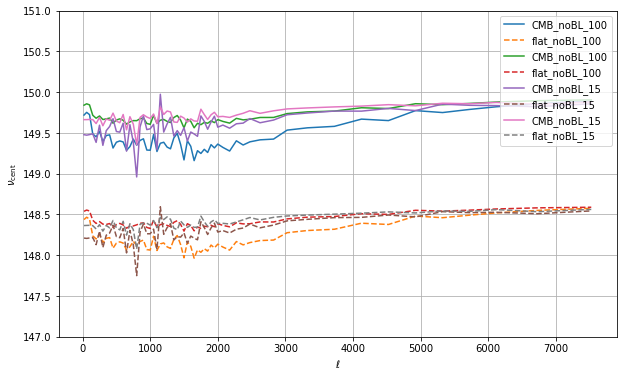

In [20]:
# evaluate coadd-weighted central frequency for CMB responses, as this cannot be computed via Hasselfield effective freq.
# note that this is NOT USED in the likelihood
N_nu_ACTPol = 3
nu_150_arr = [nu_ACTPol[0],nu_ACTPol[1],nu_ACTPol[3]]
nu_150_arr_BL = [nu_ACTPol[0],nu_ACTPol[1],nu_ACTPol[5]] #with blue leak in PA3
fnu_150_arr = [fnu_ACTPol[0],fnu_ACTPol[1],fnu_ACTPol[3]]
fnu_150_arr_BL = [fnu_ACTPol[0],fnu_ACTPol[1],fnu_ACTPol[5]] #with blue leak in PA3

ref_ind = 48 #ell=3025.5

print("--- 100 mJy Patches ---:")
print("--- No Blue Leak ---:")
CMB_noBL_100 = central_freq_coadd(nu_150_arr, fnu_150_arr, N_nu_ACTPol, ifpcov_100mJy, ifpcov_ibin_100mJy, 'CMB')
flat_noBL_100 = central_freq_coadd(nu_150_arr, fnu_150_arr, N_nu_ACTPol, ifpcov_100mJy, ifpcov_ibin_100mJy, 'flat')                 
print("CMB:", CMB_noBL_100[ref_ind])
print("flat:", flat_noBL_100[ref_ind])
print("--- With Blue Leak ---:")
CMB_BL_100 = central_freq_coadd(nu_150_arr_BL, fnu_150_arr_BL, N_nu_ACTPol, ifpcov_100mJy, ifpcov_ibin_100mJy, 'CMB')
flat_BL_100 = central_freq_coadd(nu_150_arr_BL, fnu_150_arr_BL, N_nu_ACTPol, ifpcov_100mJy, ifpcov_ibin_100mJy, 'flat')
print("CMB:", CMB_BL_100[ref_ind])
print("flat:", flat_BL_100[ref_ind])

print("--- 15 mJy Patches ---:")
print("--- No Blue Leak ---:")
CMB_noBL_15 = central_freq_coadd(nu_150_arr, fnu_150_arr, N_nu_ACTPol, ifpcov_15mJy, ifpcov_ibin_15mJy, 'CMB')
flat_noBL_15 = central_freq_coadd(nu_150_arr, fnu_150_arr, N_nu_ACTPol, ifpcov_15mJy, ifpcov_ibin_15mJy, 'flat')                 
print("CMB:", CMB_noBL_15[ref_ind])
print("flat:", flat_noBL_15[ref_ind])
print("--- With Blue Leak ---:")
CMB_BL_15 = central_freq_coadd(nu_150_arr_BL, fnu_150_arr_BL, N_nu_ACTPol, ifpcov_15mJy, ifpcov_ibin_15mJy, 'CMB')
flat_BL_15 = central_freq_coadd(nu_150_arr_BL, fnu_150_arr_BL, N_nu_ACTPol, ifpcov_15mJy, ifpcov_ibin_15mJy, 'flat')
print("CMB:", CMB_BL_15[ref_ind])
print("flat:", flat_BL_15[ref_ind])

# plot
plt.figure(figsize=(10,6))
plt.plot(ell_bin,CMB_noBL_100,label='CMB_noBL_100')
plt.plot(ell_bin,flat_noBL_100,label='flat_noBL_100', ls='--')
plt.plot(ell_bin,CMB_BL_100,label='CMB_noBL_100')
plt.plot(ell_bin,flat_BL_100,label='flat_noBL_100', ls='--')
plt.plot(ell_bin,CMB_noBL_15,label='CMB_noBL_15')
plt.plot(ell_bin,flat_noBL_15,label='flat_noBL_15', ls='--')
plt.plot(ell_bin,CMB_BL_15,label='CMB_noBL_15')
plt.plot(ell_bin,flat_BL_15,label='flat_noBL_15', ls='--')
plt.legend(loc=0)
plt.grid()
plt.ylim(np.min(freq)-1,np.max(freq)+1)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\nu_{\rm cent}$')
plt.show()
plt.savefig('PA123_CMB_centfreq_noBL_BL_100mJy_15mJy_20200222.pdf')

In [21]:
# Effective frequency to diffuse sources -- note that compact sources differ!
# This uses the Hasselfield Eq. 15 approach
# The effective frequency is defined as the solution nu0 of the equation
# 1/S(nu0) \int d\nu S(\nu) f(\nu) = 1/D_CMB(nu0) \int d\nu D_CMB(\nu) f(\nu)
# where S(\nu) is the SED of the component of interest
# and f(\nu) is the bandpass transmission
# Co-add version using Steve's weights
N_search = 200000
def eff_freq_coadd(nu_arr, fnu_arr, N_nu, ifpcov, ifpcov_ibin, SED_choice):
    '''
    Input:
    nu_arr = list of arrays containing frequencies at which bandpasses are measured [GHz]
    fnu_arr = list of arrays containing bandpass transmission measurements [dimensionless]
    N_nu = number of arrays
    ifpcov, ifpcov_ibin = inverted cov matrices from Steve
    SED_choice = one of {CMB, tSZ, CIB, dust, radio, synch}
    Output:
    effective frequency [GHz]
    '''
    assert(SED_choice is not None)
    snu_arr = copy(nu_arr)
    snu_CMB_arr = copy(nu_arr)
    # compute LHS of Eq. 15 on a grid
    # move the ratio of the nu0-related things to the LHS
    nu0_arr = np.linspace(1.,300.,num=N_search)
    snu0_CMB = nu_be_CMB(nu0_arr)
    LHS_numerator = snu0_CMB
    # need CMB bandpass integrals
    for i in range(N_nu):
        snu_CMB_arr[i] = nu_be_CMB(nu_arr[i])
    if (SED_choice == 'CMB'):
        #snu = nu_be_CMB(nu)
        print("eff. freq. undefined for CMB")
        return -np.inf
    elif (SED_choice == 'tSZ'):
        for i in range(N_nu):
            snu_arr[i] = nu_be_SZ(nu_arr[i])
        snu0_arr = nu_be_SZ(nu0_arr)
    elif (SED_choice == 'CIB'):
        for i in range(N_nu):
            snu_arr[i] = nu_be_MBB(nu_arr[i], be_CIB, 9.6)
        snu0_arr = nu_be_MBB(nu0_arr, be_CIB, 9.6)
    elif (SED_choice == 'dust'):
        for i in range(N_nu):
            # UPDATE 3-12-20: Galactic dust now modeled as a MBB in the likelihood
            #snu_arr[i] = nu_be_PL(nu_arr[i], be_d)
            snu_arr[i] = nu_be_MBB(nu_arr[i], be_d, T_dust=T_d_Gal)
        #snu0_arr = nu_be_PL(nu0_arr, be_d)
        snu0_arr = nu_be_MBB(nu0_arr, be_d, T_dust=T_d_Gal)
    elif (SED_choice == 'radio'):
        for i in range(N_nu):
            snu_arr[i] = nu_be_PL(nu_arr[i], be_radio)
        snu0_arr = nu_be_PL(nu0_arr, be_radio)
    elif (SED_choice == 'synch'):
        for i in range(N_nu):
            snu_arr[i] = nu_be_PL(nu_arr[i], be_s)
        snu0_arr = nu_be_PL(nu0_arr, be_s)
    elif (SED_choice == 'flat'):
        for i in range(N_nu):
            snu_arr[i] = nu_be_PL(nu_arr[i], 0.)
        snu0_arr = nu_be_PL(nu0_arr, 0.)
    else:
        print("unknown SED")
        return -np.inf
    # evaluate sums and integrals over bandpasses
    # RHS of Eq. 15, moving the ratio of the two integrals to the RHS
    RHS_numerator_arr = np.zeros(N_nu)
    RHS_denominator_arr = np.zeros(N_nu)
    for i in range(N_nu):
        RHS_numerator_arr[i] = np.trapz(fnu_arr[i] * snu_CMB_arr[i], x=nu_arr[i])
        RHS_denominator_arr[i] = np.trapz(fnu_arr[i] * snu_arr[i], x=nu_arr[i])
    RHS_numerator = np.ones(nbins)*RHS_numerator_arr[0]
    RHS_denominator = np.ones(nbins)*RHS_denominator_arr[0]
    for i in range(1,N_nu):
        RHS_numerator = np.append(RHS_numerator,np.ones(nbins)*RHS_numerator_arr[i])
        RHS_denominator = np.append(RHS_denominator,np.ones(nbins)*RHS_denominator_arr[i])
    RHS = np.dot(ifpcov_ibin,np.dot(fpmat,np.dot(ifpcov,RHS_numerator))) / np.dot(ifpcov_ibin,np.dot(fpmat,np.dot(ifpcov,RHS_denominator)))
    # LHS of Eq. 15, with the ratio of the nu0-related things
    LHS_denominator = snu0_arr
    LHS_arr = LHS_numerator / LHS_denominator
    # solve Eq. 15 at each ell_bin
    nu_eff = np.zeros(nbins)
    for k in range(nbins):
        ind_min = np.argmin(np.absolute(LHS_arr - RHS[k]))
        nu_eff[k] = nu0_arr[ind_min]
    return nu_eff

--- 100 mJy Patches ---:
--- No Blue Leak ---:
tSZ: 149.93712968564842
CIB: 150.93429967149834
dust: 150.82366911834558
radio: 147.13698068490342
synch: 147.01289506447532
--- With Blue Leak ---:
tSZ: 150.159885799429
CIB: 151.24974624873124
dust: 151.13164065820328
radio: 147.24611623058115
synch: 147.12352561762808
--- 15 mJy Patches ---:
--- No Blue Leak ---:
tSZ: 150.13746068730342
CIB: 151.16453082265411
dust: 151.05091025455127
radio: 147.240136200681
synch: 147.1115655578278
--- With Blue Leak ---:
tSZ: 150.2166960834804
CIB: 151.27516137580687
dust: 151.160045800229
radio: 147.27900639503196
synch: 147.1519307596538


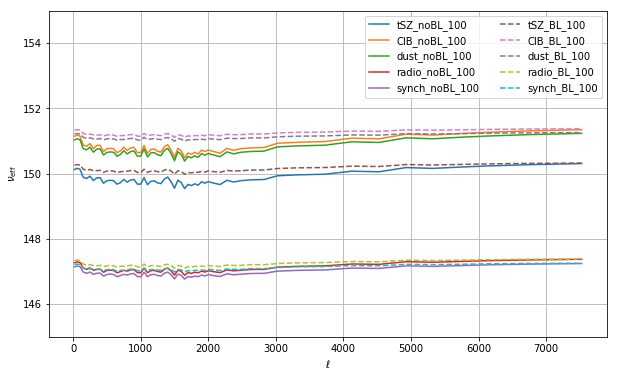

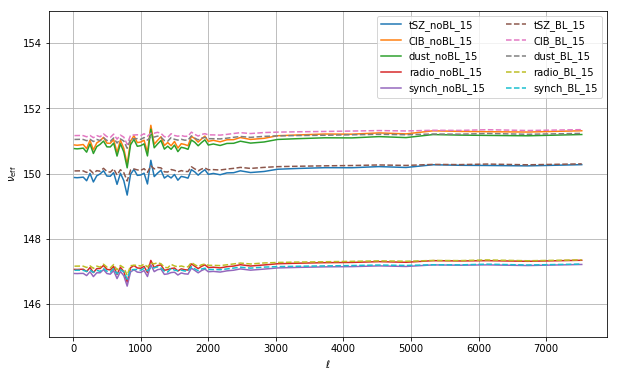

In [22]:
print("--- 100 mJy Patches ---:")
print("--- No Blue Leak ---:")
tSZ_noBL_100 = eff_freq_coadd(nu_150_arr, fnu_150_arr, N_nu_ACTPol, ifpcov_100mJy, ifpcov_ibin_100mJy, 'tSZ')
CIB_noBL_100 = eff_freq_coadd(nu_150_arr, fnu_150_arr, N_nu_ACTPol, ifpcov_100mJy, ifpcov_ibin_100mJy, 'CIB')
dust_noBL_100 = eff_freq_coadd(nu_150_arr, fnu_150_arr, N_nu_ACTPol, ifpcov_100mJy, ifpcov_ibin_100mJy, 'dust')
radio_noBL_100 = eff_freq_coadd(nu_150_arr, fnu_150_arr, N_nu_ACTPol, ifpcov_100mJy, ifpcov_ibin_100mJy, 'radio')
synch_noBL_100 = eff_freq_coadd(nu_150_arr, fnu_150_arr, N_nu_ACTPol, ifpcov_100mJy, ifpcov_ibin_100mJy, 'synch')
print("tSZ:", tSZ_noBL_100[ref_ind])
print("CIB:", CIB_noBL_100[ref_ind])
print("dust:", dust_noBL_100[ref_ind])
print("radio:", radio_noBL_100[ref_ind])
print("synch:", synch_noBL_100[ref_ind])

print("--- With Blue Leak ---:")
tSZ_BL_100 = eff_freq_coadd(nu_150_arr_BL, fnu_150_arr_BL, N_nu_ACTPol, ifpcov_100mJy, ifpcov_ibin_100mJy, 'tSZ')
CIB_BL_100 = eff_freq_coadd(nu_150_arr_BL, fnu_150_arr_BL, N_nu_ACTPol, ifpcov_100mJy, ifpcov_ibin_100mJy, 'CIB')
dust_BL_100 = eff_freq_coadd(nu_150_arr_BL, fnu_150_arr_BL, N_nu_ACTPol, ifpcov_100mJy, ifpcov_ibin_100mJy, 'dust')
radio_BL_100 = eff_freq_coadd(nu_150_arr_BL, fnu_150_arr_BL, N_nu_ACTPol, ifpcov_100mJy, ifpcov_ibin_100mJy, 'radio')
synch_BL_100 = eff_freq_coadd(nu_150_arr_BL, fnu_150_arr_BL, N_nu_ACTPol, ifpcov_100mJy, ifpcov_ibin_100mJy, 'synch')
print("tSZ:", tSZ_BL_100[ref_ind])
print("CIB:", CIB_BL_100[ref_ind])
print("dust:", dust_BL_100[ref_ind])
print("radio:", radio_BL_100[ref_ind])
print("synch:", synch_BL_100[ref_ind])

print("--- 15 mJy Patches ---:")
print("--- No Blue Leak ---:")
tSZ_noBL_15 = eff_freq_coadd(nu_150_arr, fnu_150_arr, N_nu_ACTPol, ifpcov_15mJy, ifpcov_ibin_15mJy, 'tSZ')
CIB_noBL_15 = eff_freq_coadd(nu_150_arr, fnu_150_arr, N_nu_ACTPol, ifpcov_15mJy, ifpcov_ibin_15mJy, 'CIB')
dust_noBL_15 = eff_freq_coadd(nu_150_arr, fnu_150_arr, N_nu_ACTPol, ifpcov_15mJy, ifpcov_ibin_15mJy, 'dust')
radio_noBL_15 = eff_freq_coadd(nu_150_arr, fnu_150_arr, N_nu_ACTPol, ifpcov_15mJy, ifpcov_ibin_15mJy, 'radio')
synch_noBL_15 = eff_freq_coadd(nu_150_arr, fnu_150_arr, N_nu_ACTPol, ifpcov_15mJy, ifpcov_ibin_15mJy, 'synch')
print("tSZ:", tSZ_noBL_15[ref_ind])
print("CIB:", CIB_noBL_15[ref_ind])
print("dust:", dust_noBL_15[ref_ind])
print("radio:", radio_noBL_15[ref_ind])
print("synch:", synch_noBL_15[ref_ind])

print("--- With Blue Leak ---:")
tSZ_BL_15 = eff_freq_coadd(nu_150_arr_BL, fnu_150_arr_BL, N_nu_ACTPol, ifpcov_15mJy, ifpcov_ibin_15mJy, 'tSZ')
CIB_BL_15 = eff_freq_coadd(nu_150_arr_BL, fnu_150_arr_BL, N_nu_ACTPol, ifpcov_15mJy, ifpcov_ibin_15mJy, 'CIB')
dust_BL_15 = eff_freq_coadd(nu_150_arr_BL, fnu_150_arr_BL, N_nu_ACTPol, ifpcov_15mJy, ifpcov_ibin_15mJy, 'dust')
radio_BL_15 = eff_freq_coadd(nu_150_arr_BL, fnu_150_arr_BL, N_nu_ACTPol, ifpcov_15mJy, ifpcov_ibin_15mJy, 'radio')
synch_BL_15 = eff_freq_coadd(nu_150_arr_BL, fnu_150_arr_BL, N_nu_ACTPol, ifpcov_15mJy, ifpcov_ibin_15mJy, 'synch')
print("tSZ:", tSZ_BL_15[ref_ind])
print("CIB:", CIB_BL_15[ref_ind])
print("dust:", dust_BL_15[ref_ind])
print("radio:", radio_BL_15[ref_ind])
print("synch:", synch_BL_15[ref_ind])

# plot: 100 mJy patches
plt.figure(figsize=(10,6))
plt.plot(ell_bin,tSZ_noBL_100,label='tSZ_noBL_100')
plt.plot(ell_bin,CIB_noBL_100,label='CIB_noBL_100')
plt.plot(ell_bin,dust_noBL_100,label='dust_noBL_100')
plt.plot(ell_bin,radio_noBL_100,label='radio_noBL_100')
plt.plot(ell_bin,synch_noBL_100,label='synch_noBL_100')
plt.plot(ell_bin,tSZ_BL_100,label='tSZ_BL_100', ls='--')
plt.plot(ell_bin,CIB_BL_100,label='CIB_BL_100', ls='--')
plt.plot(ell_bin,dust_BL_100,label='dust_BL_100', ls='--')
plt.plot(ell_bin,radio_BL_100,label='radio_BL_100', ls='--')
plt.plot(ell_bin,synch_BL_100,label='synch_BL_100', ls='--')
plt.legend(loc=0, ncol=2)
plt.grid()
plt.ylim(145.,155.)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\nu_{\rm eff}$')
plt.show()
plt.savefig('PA123_efffreq_noBL_BL_100mJy_20200222.pdf')

# plot: 15 mJy patches
plt.figure(figsize=(10,6))
plt.plot(ell_bin,tSZ_noBL_15,label='tSZ_noBL_15')
plt.plot(ell_bin,CIB_noBL_15,label='CIB_noBL_15')
plt.plot(ell_bin,dust_noBL_15,label='dust_noBL_15')
plt.plot(ell_bin,radio_noBL_15,label='radio_noBL_15')
plt.plot(ell_bin,synch_noBL_15,label='synch_noBL_15')
plt.plot(ell_bin,tSZ_BL_15,label='tSZ_BL_15', ls='--')
plt.plot(ell_bin,CIB_BL_15,label='CIB_BL_15', ls='--')
plt.plot(ell_bin,dust_BL_15,label='dust_BL_15', ls='--')
plt.plot(ell_bin,radio_BL_15,label='radio_BL_15', ls='--')
plt.plot(ell_bin,synch_BL_15,label='synch_BL_15', ls='--')
plt.legend(loc=0, ncol=2)
plt.grid()
plt.ylim(145.,155.)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\nu_{\rm eff}$')
plt.show()
plt.savefig('PA123_efffreq_noBL_BL_15mJy_20200222.pdf')